# Smart E-commerce Catalog Data Analysis

## 3. Data Analysis Part 2 - Advanced EDA on E-commerce Data
Having extracted the basic metrics in SQL, I'm now shifting my focus to conducting deeper analysis in Python.

**1- Loading the Dataset**

In [0]:
#Load the dataset
product_df = spark.sql("SELECT * FROM product_db.product_table")
product_pd_df = product_df.toPandas()
product_pd_df.head(10)

,product_id,product_name,category,price,stock,rating,launch_date,description,is_active
0,251,Product 251,Home,474.100006,62,1.8,2024-08-21,This is a great product.,True
1,252,Product 252,Electronics,151.419998,100,1.4,2024-01-28,This is a great product.,True
2,253,Product 253,Home,438.809998,79,1.5,2024-04-21,This is a great product.,True
3,254,Product 254,Clothing,94.519997,88,4.1,2024-08-07,This is a great product.,False
4,255,Product 255,Electronics,208.380005,86,3.9,2024-03-17,This is a great product.,False
5,256,Product 256,Books,120.830002,30,2.2,2024-03-04,This is a great product.,True
6,257,Product 257,Home,340.760010,73,4.9,2024-03-08,This is a great product.,False
7,258,Product 258,Books,253.940002,53,4.9,2024-07-20,This is a great product.,True
8,259,Product 259,Home,30.830000,61,4.5,2024-01-21,This is a great product.,True
9,260,Product 260,Toys,426.329987,36,1.3,2024-08-09,This is a great product.,False


In [0]:
import pandas as pd

In [0]:
#Get summary statistics 
print(product_pd_df.info())
product_pd_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   product_id    1000 non-null   int32  
 1   product_name  1000 non-null   object 
 2   category      1000 non-null   object 
 3   price         997 non-null    float32
 4   stock         1000 non-null   int32  
 5   rating        1000 non-null   float32
 6   launch_date   1000 non-null   object 
 7   description   1000 non-null   object 
 8   is_active     1000 non-null   bool   
dtypes: bool(1), float32(2), int32(2), object(4)
memory usage: 48.0+ KB
None


,product_id,price,stock,rating
count,1000.000000,997.000000,1000.00000,1000.000000
mean,500.500000,254.441696,49.76100,2.966700
std,288.819436,143.719666,29.08945,1.171278
min,1.000000,6.320000,0.00000,1.000000
25%,250.750000,134.500000,25.00000,1.900000
50%,500.500000,254.149994,50.00000,3.000000
75%,750.250000,379.179993,74.00000,4.000000
max,1000.000000,499.799988,100.00000,5.000000


**2- Missing Data**

Checking, and handling missing data.

In [0]:
product_pd_df.isna().sum()

product_id      0
product_name    0
category        0
price           3
stock           0
rating          0
launch_date     0
description     0
is_active       0
dtype: int64

In [0]:
#Checking missing values
missing_data = product_pd_df.isnull().mean() * 100  # Percentage of missing data
print(missing_data)

product_id      0.0
product_name    0.0
category        0.0
price           0.3
stock           0.0
rating          0.0
launch_date     0.0
description     0.0
is_active       0.0
dtype: float64


The only column that has missing data is `price`,  which has `0.3%` of its entries missing.

**Impact of Missing Data:**

Analyze if there’s a relationship between missing values in price or rating and any other features.

In [0]:
product_pd_df['price_missing'] = product_pd_df['price'].isnull()
product_pd_df['rating_missing'] = product_pd_df['rating'].isnull()
price_missing_impact = product_pd_df.groupby('price_missing')['stock'].mean()
print("Average Stock by Price Missing:", price_missing_impact)


Average Stock by Price Missing: price_missing
False    49.781344
True     43.000000
Name: stock, dtype: float64


An analysis was conducted to explore the relationship between missing values in the `price` column and the average stock levels of products.

- **Average Stock by Price Missing**:
  - **Products with Price Present**: 49.78
  - **Products with Missing Price**: 43.00

This indicates that products with missing price data tend to have a lower average stock compared to those with available price information. This insight may suggest that missing price values could be associated with inventory management issues or the categorization of products within the database. Further analysis could be beneficial to explore the implications of these missing values on sales and inventory strategies.

**Handling Missing Data**

After analyzing the dataset, I found that the only column with missing values is `price`, which accounts for only **0.3%** of the total data. Given this minimal percentage, I will proceed to drop the missing data from the dataset. This approach is justified as it will not significantly impact the overall dataset's integrity or the results of the analysis.

In [0]:
# Drop rows with missing values in the 'price' column only
product_pd_df = product_pd_df.dropna(subset=['price'])

**3- Outliers**

1- Box Plot for Outliers

Box Plot for Price Column:

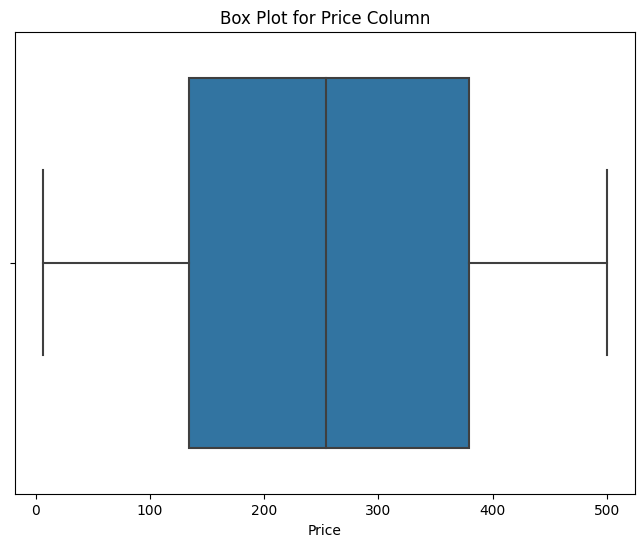

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

# Box plot for price
plt.figure(figsize=(8, 6))
sns.boxplot(x=product_pd_df['price'])
plt.title('Box Plot for Price Column')
plt.xlabel('Price')
plt.show()


Box Plot for Rating Column:


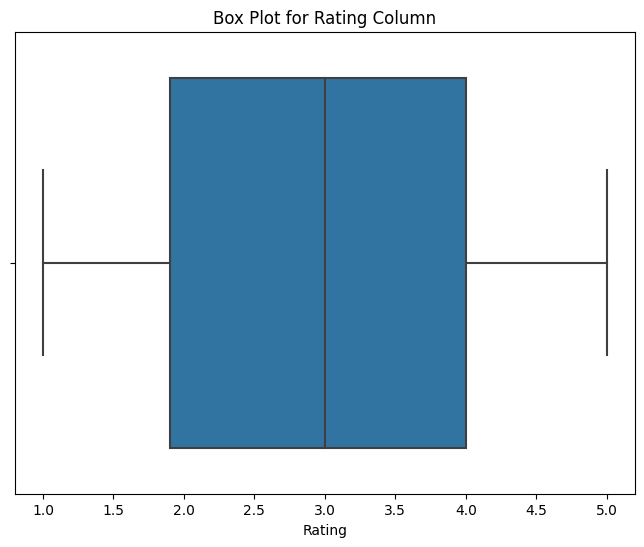

In [0]:
# Box plot for rating
plt.figure(figsize=(8, 6))
sns.boxplot(x=product_pd_df['rating'])
plt.title('Box Plot for Rating Column')
plt.xlabel('Rating')
plt.show()


2- Checking for Outliers Using Z-Score


In [0]:
from scipy import stats

# Calculate Z-scores
product_pd_df['price_zscore'] = stats.zscore(product_pd_df['price'])
product_pd_df['rating_zscore'] = stats.zscore(product_pd_df['rating'])

# Set a threshold for identifying outliers
threshold = 3

# Identify outliers in price and rating
outliers_price = product_pd_df[abs(product_pd_df['price_zscore']) > threshold]
outliers_rating = product_pd_df[abs(product_pd_df['rating_zscore']) > threshold]

# Display the outliers
if outliers_price.empty:
    print("No outliers in Price Column.")
else:
    print("Outliers in Price Column:")
    print(outliers_price)

if outliers_rating.empty:
    print("No outliers in Rating Column.")
else:
    print("Outliers in Rating Column:")
    print(outliers_rating)


No outliers in Price Column.
No outliers in Rating Column.


1. **`impute_outliers_iqr(df, column)`**: 
   - This function identifies and imputes outliers in the specified column using the Interquartile Range (IQR) method. 
   - Outliers are defined as values that fall below the first quartile (Q1) minus 1.5 times the IQR or above the third quartile (Q3) plus 1.5 times the IQR.
   - The identified outliers are replaced with the median of the column.

*Note: In the columns that we are interested in there are no outliers*

In [0]:
# This is a function I use when I need to impute outliers 
import pandas as pd

def impute_outliers_iqr(df, column):
    """
    Imputes outliers in the specified column of the DataFrame using IQR.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    column (str): The column name in which to impute outliers.
    
    Returns:
    pd.DataFrame: DataFrame with outliers imputed.
    """
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    
    # Calculate IQR
    IQR = Q3 - Q1
    
    # Define lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Impute outliers with the median
    median = df[column].median()
    df[column] = df[column].where((df[column] >= lower_bound) & (df[column] <= upper_bound), median)
    
    return df

# Example usage:
product_pd_df = impute_outliers_iqr(product_pd_df, 'price')
product_pd_df = impute_outliers_iqr(product_pd_df, 'rating')


2. **`impute_outliers_zscore(df, column, threshold=3)`**: 
   - This function identifies and imputes outliers in the specified column using the Z-score method.
   - Outliers are defined as values with an absolute Z-score greater than the specified threshold (default is 3).
   - The identified outliers are replaced with the median of the column.
   
*Note: In the columns that we are interested in there are no outliers*

In [0]:
import pandas as pd
from scipy import stats

def impute_outliers_zscore(df, column, threshold=3):
    """
    Imputes outliers in the specified column of the DataFrame using Z-score method.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    column (str): The column name in which to impute outliers.
    threshold (float): The Z-score threshold for identifying outliers.
    
    Returns:
    pd.DataFrame: DataFrame with outliers imputed.
    """
    # Calculate Z-scores for the specified column
    z_scores = stats.zscore(df[column])
    
    # Calculate the median for imputation
    median = df[column].median()
    
    # Impute outliers with the median
    df[column] = df[column].where(abs(z_scores) <= threshold, median)
    
    return df

# Example usage:
product_pd_df = impute_outliers_zscore(product_pd_df, 'price', threshold=3)
product_pd_df = impute_outliers_zscore(product_pd_df, 'rating', threshold=3)


**4 - The Distributions**

Plotting the distribution of the two columns ( `price` and `rating`) using matplotlib and seaborn.

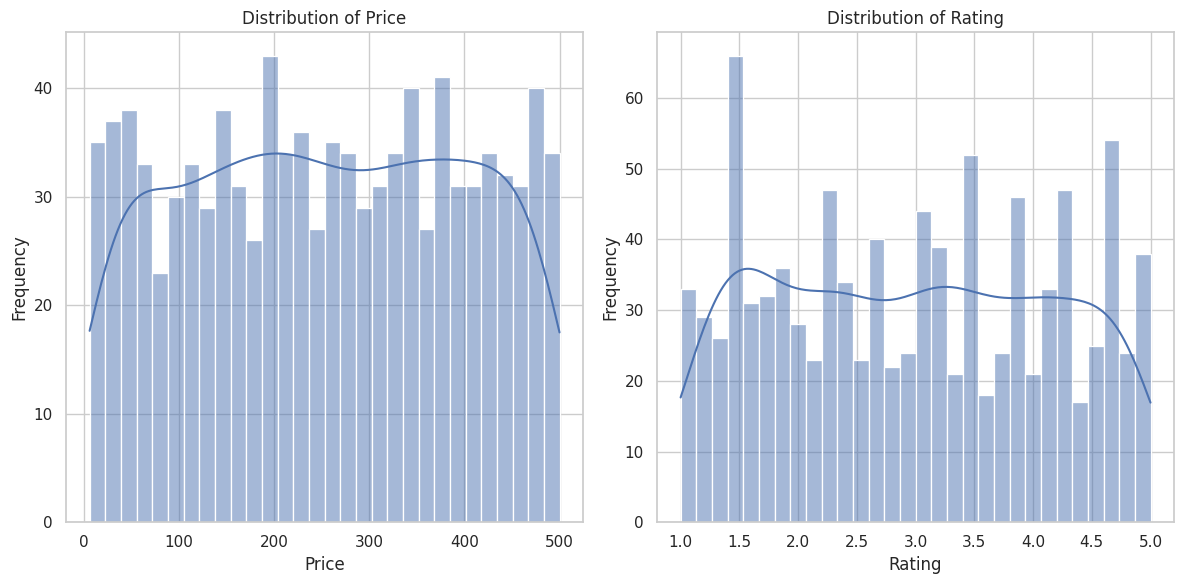

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of seaborn
sns.set(style='whitegrid')

# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot the distribution of the 'price' column
sns.histplot(product_pd_df['price'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Price')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Frequency')

# Plot the distribution of the 'rating' column
sns.histplot(product_pd_df['rating'], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Distribution of Rating')
axes[1].set_xlabel('Rating')
axes[1].set_ylabel('Frequency')

# Show the plots
plt.tight_layout()
plt.show()


Plotting the distribution of the `category` column 

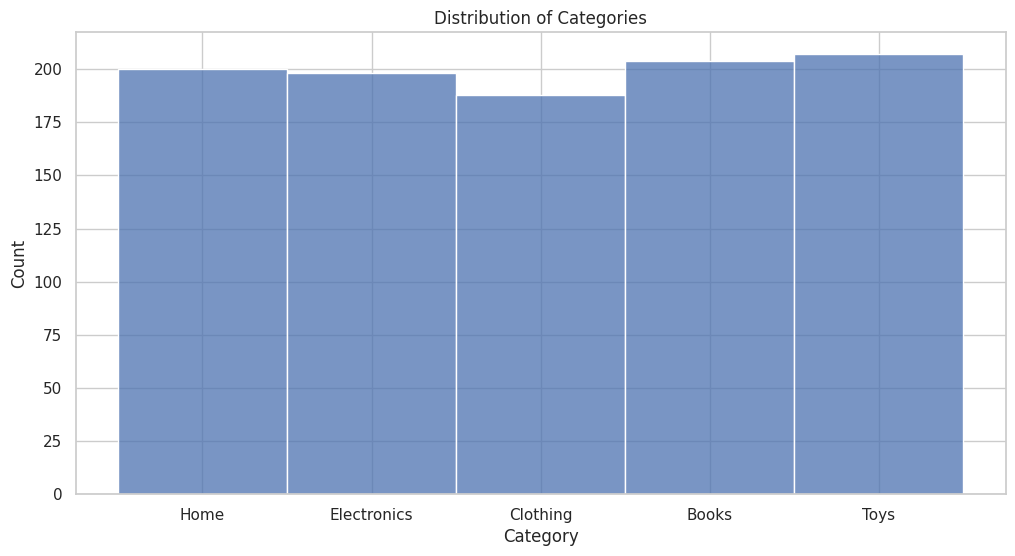

In [0]:
plt.figure(figsize=(12, 6))
# Plot the distribution of the 'category' column
sns.histplot(product_pd_df['category'])
plt.title('Distribution of Categories')
plt.xlabel('Category')
plt.ylabel('Count')

plt.show()

`category` column Pie chart

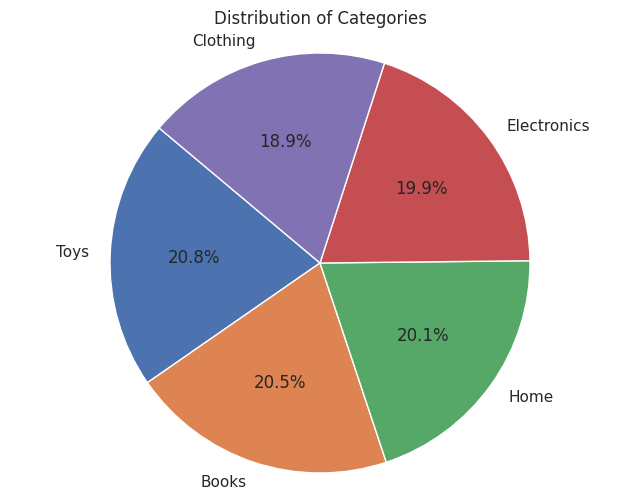

In [0]:

# Count the occurrences of each category
category_counts = product_pd_df['category'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Categories')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular
plt.show()


**Distribution Observations**

The distributions of the price, rating, and category columns are uniform. This indicates that the values are evenly distributed across their respective ranges, suggesting a balanced representation of products in terms of pricing, ratings, and categories.

**Category Rating**


In [0]:
product_pd_df['rating'].mean()

2.964594

In [0]:
product_pd_df.groupby('category')['rating'].mean()

category
Books          3.138235
Clothing       2.913830
Electronics    3.047980
Home           2.858000
Toys           2.862802
Name: rating, dtype: float32

In [0]:
product_pd_df['category'].value_counts()

Toys           207
Books          204
Home           200
Electronics    198
Clothing       188
Name: category, dtype: int64

- Most category users tending to rate.

In [0]:

#Count the number of ratings per category
ratings_per_category = product_pd_df.groupby('category')['rating'].count().reset_index()

# Rename the columns for clarity
ratings_per_category.columns = ['category', 'rating_count']
ratings_per_category

,category,rating_count
0,Books,204
1,Clothing,188
2,Electronics,198
3,Home,200
4,Toys,207


- There is no most category users tending to rate, 
That was predicted because there are no missing values in the rating column.

- A bar plot for most rated category

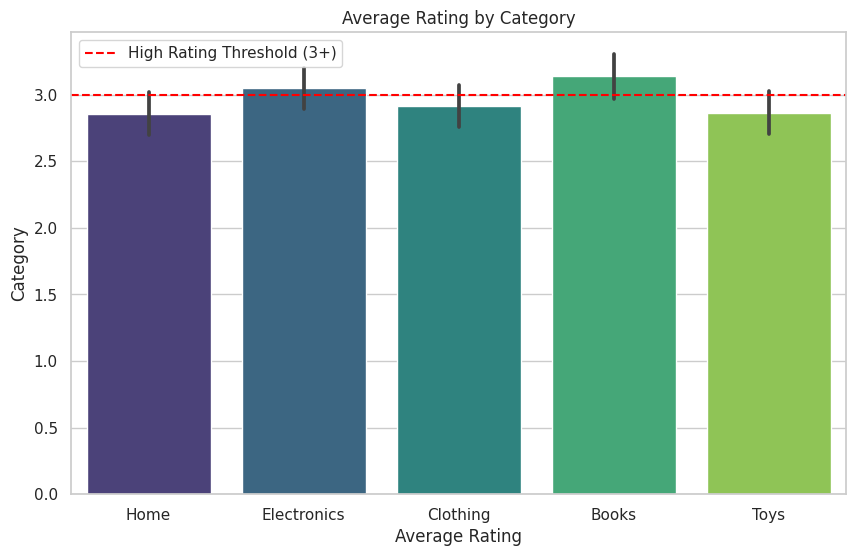

In [0]:
# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=product_pd_df, x='category', y='rating', palette='viridis')

# Add title and labels
plt.title('Average Rating by Category')
plt.xlabel('Average Rating')
plt.ylabel('Category')

# Add a high rating threshold line (optional)
plt.axhline(y=3, color='red', linestyle='--', label='High Rating Threshold (3+)')
plt.legend()

# Show the plot
plt.show()

The bar plot illustrates the average ratings for each category. Notably, only the **Books** and **Electronics** categories exceed the threshold rating of 3. This indicates that these categories are perceived more favorably by users compared to others.


**5- Rating Distribution and Feature Engineering Prep**

Rating Binarization (for logistic regression): Creating a target column for ratings ≥ 4.

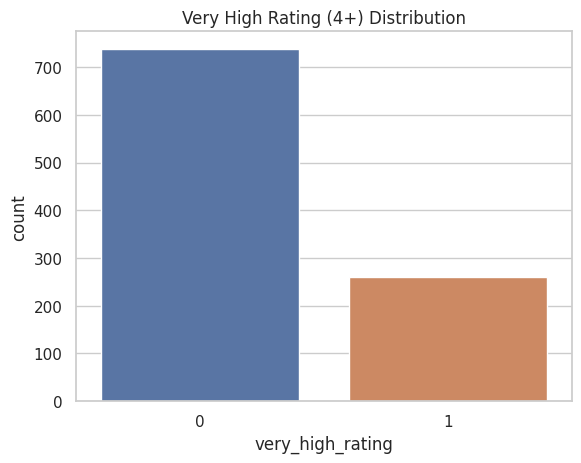

0    0.740221
1    0.259779
Name: very_high_rating, dtype: float64


In [0]:

product_pd_df['very_high_rating'] = (product_pd_df['rating'] >= 4).astype(int)
sns.countplot(data=product_pd_df, x='very_high_rating')
plt.title('Very High Rating (4+) Distribution')
plt.show()


# Print the normalized value counts of the 'high_rating' column, 
# which indicates the proportion of ratings that are classified as high (4 or above) 
# compared to the total number of ratings.
print(product_pd_df['very_high_rating'].value_counts(normalize=True))

The analysis reveals that approximately `74.02%` of the ratings fall below the threshold of 4,
 while around `25.98`% of the ratings are classified as high ratings (`4` or above). This indicates a significant portion of users are providing ratings less than 4, suggesting room for improvement in user satisfaction.